# EXPJ30 qPCR analysis


In [1]:
import numpy
import sys
sys.path.append("/Users/jdemaray/Dropbox (Gladstone)/Jack/Computational/instrument_scripts/")


from qPCR import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

path = "/Users/jdemaray/Dropbox (Gladstone)/Jack/Experiments/EXPJ30/"

GOI_list = ['ACTB', 'ACTB', 'CCL20', 'CCL20', 'CX3CL1', 'CX3CL1'] \
+ [None for i in range(18)]
cell_lines = {
        "A"	: "34",
        "B"	: "42",
        "C"	: "35",
        "D"	: "43",
        "E"	: "36",
        "F"	: "44",
        "G"	: "37",
        "H"	: "45",
        "I"	: "38",
        "J"	: "Transduction (-)",
        "K"	: "39",
        "L"	: "Water",
        "M"	: "40",
        "N"	: np.nan,
        "O"	: "41",
        "P"	: np.nan
    }

In [2]:
import string
ctdf = pd.read_csv(path+'20230925_EXPJ30_qPCR -  Quantification Cq Results.csv')
define_genes_samples(ctdf, GOI_list, cell_lines)
ct384 = get_ct_384(ctdf)

# ct384.dropna()
# empty_wells = [letter + "02" for letter in string.ascii_uppercase[:14]] + \
#     [letter + "04" for letter in string.ascii_uppercase[:14]] + \
#     [letter + "06" for letter in string.ascii_uppercase[:14]]
# empty_wells
ct384.dropna(inplace=True)
# ct384 = ct384[~ct384["Well"].isin(empty_wells)]
# ct384.to_excel(path+"Ct_values_annotated_2.xlsx")


In [3]:
ct384[['row', 'column']] = ct384["Well"].str.split("0", expand=True)
ct384.replace(0, np.nan, inplace=True)

layout = pd.DataFrame({i : {c : float(ct384.loc[(ct384.row == i) & (ct384.column == c), "Cq Mean"].values) for c in ct384.column.unique()} for i in ct384.row.unique()}).T
layout.sort_index(axis=1, inplace=True)
layout.sort_index(inplace=True)
layout.style.background_gradient(cmap='binary')

/var/folders/jv/gbxqq9fn27d28j169k55b6s00000gq/T/ipykernel_6997/1456247344.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  layout = pd.DataFrame({i : {c : float(ct384.loc[(ct384.row == i) & (ct384.column == c), "Cq Mean"].values) for c in ct384.column.unique()} for i in ct384.row.unique()}).T


,1,2,3,4,5,6
A,nan,24.470224,42.198038,38.112307,29.387316,28.878333
B,43.156391,24.178162,nan,nan,28.675931,27.041231
C,nan,24.530057,44.080291,39.777394,28.929080,28.489295
D,38.514096,22.583524,nan,nan,28.857461,27.629503
E,44.107766,23.418863,nan,nan,31.113870,30.960403
F,nan,18.345687,nan,35.599775,24.615056,23.205330
G,nan,21.307404,nan,34.671900,29.233858,27.856853
H,33.548748,21.437110,nan,34.811811,24.061265,22.560544
I,32.610899,21.115373,nan,35.861292,27.432648,26.778102
J,26.224733,20.613311,nan,37.484984,26.725297,25.306987


# ∆∆Ct and fold change calculations
$$activation = \frac{fold change + efficiency - 1}{efficiency}\$$

In [4]:
from uncertainties import ufloat

ct384.replace(0.0, 46.0, inplace=True)
ct_df = pd.DataFrame(columns=ct384.GOI.unique(), index=[i for i in ct384.Cytokine.unique() if i != "Water"])
for index, row in ct_df.iterrows():
    for gene in ct_df.columns:
        Ct = ct384.loc[(ct384["GOI"]==gene) & (ct384["Cytokine"]==index), "Cq Mean"]
        ct_df.loc[index, gene] = ufloat(np.mean(Ct), np.std(Ct))
        # print(ct384.loc[(ct384["GOI"]==gene) & (ct384["Cytokine"]==index)])
ct_df.sort_index(inplace=True)
dct_df = pd.DataFrame(columns=[i for i in ct_df.columns if i != "ACTB"], index=ct_df.index)
for index, row in dct_df.iterrows():
    for gene in dct_df.columns:
        dCt = ct_df.loc[index, gene] - ct_df.loc[index, "ACTB"]
        dct_df.loc[index, gene] = dCt
ddct_df = pd.DataFrame(columns=dct_df.columns, index=[i for i in dct_df.index if i != "Transduction (-)"])
for index, row in ddct_df.iterrows():
    for gene in ddct_df.columns:
        ddCt = dct_df.loc[index, gene] - dct_df.loc["Transduction (-)", gene]
        ddct_df.loc[index, gene] = ddCt
fold_changes = ddct_df.apply((lambda x: 2**-x))
unpacked_column_names = [f"{i} Fold Change" for i in ddct_df.columns]+\
                       [f"{i} stdev" for i in ddct_df.columns]
unpacked_column_names.sort()
fc_plot = pd.DataFrame(columns=unpacked_column_names,
                       index=ddct_df.index)
fc_plot
# fc_plot.columns.sort_values()
for index, row in fc_plot.iterrows():
    for gene in fold_changes.columns:
        fc_plot.loc[index, f"{gene} Fold Change"]=fold_changes.loc[index, gene].nominal_value
        fc_plot.loc[index, f"{gene} stdev"]=float(fold_changes.loc[index, gene].std_dev)
# fold_changes.hist()
fc_plot.plot.bar(y="CCL20 Fold Change", yerr="CCL20 stdev", facecolor="none", edgecolor='k', capsize=5)
plt.axhline(y=1, c='k', linestyle=':')
fc_plot.plot.bar(y="CX3CL1 Fold Change", yerr="CX3CL1 stdev", facecolor="none", edgecolor='k', capsize=5)
plt.axhline(y=1, c='k', linestyle=':')
# plt.hist(x=fc_plot, bins=fc_plot.index)

AttributeError: 'DataFrame' object has no attribute 'Cytokine'

In [ ]:
# fold_changes
# efficiencies = pd.Series({"CL0021" : 0.168,
# "CL0022" : 0.207,
# "CL0023" : 0.175,
# "CL0024" : 0.082,
# "CL0025" : 0.099,
# "CL0026" : 0.153,
# "CL0027" : 0.109})
# fold_changes["efficiency"] = efficiencies
# fold_changes.dtypes
# fold_changes["CXCL10_estimated_activation"] = (fold_changes["CXCL10"] + fold_changes["efficiency"] - 1) / fold_changes["efficiency"]
# fold_changes

In [ ]:
# # Plotting estimated efficiencies
# values = fold_changes["CXCL10_estimated_activation"].apply(lambda x: x.nominal_value)
# stdevs = fold_changes["CXCL10_estimated_activation"].apply(lambda x: x.std_dev)
# x = np.arange(len(values))
# plt.bar(x, values, yerr=stdevs, capsize=5, facecolor='none', edgecolor='k', align='center')
# plt.ylabel("Estimated Activation")
# plt.xticks(x, fold_changes.index)
# plt.axhline(y=1, c='k', linestyle=':')
# plt.show()

# Melting curves

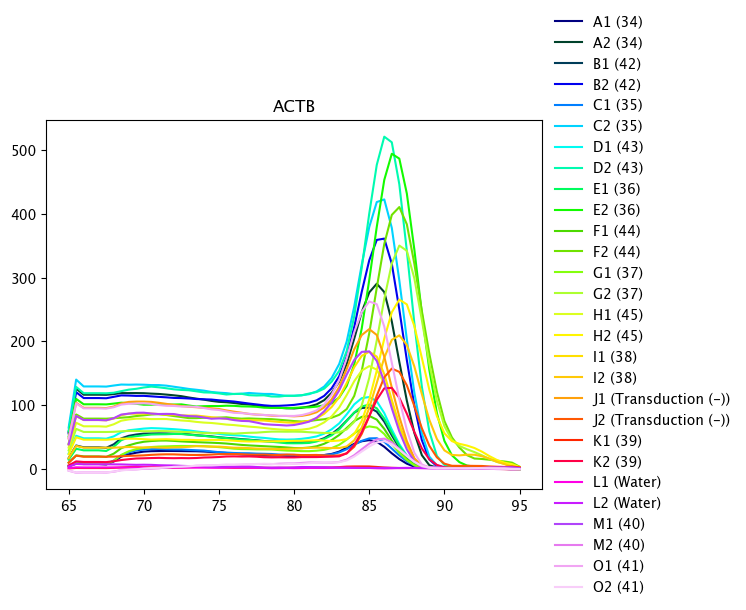

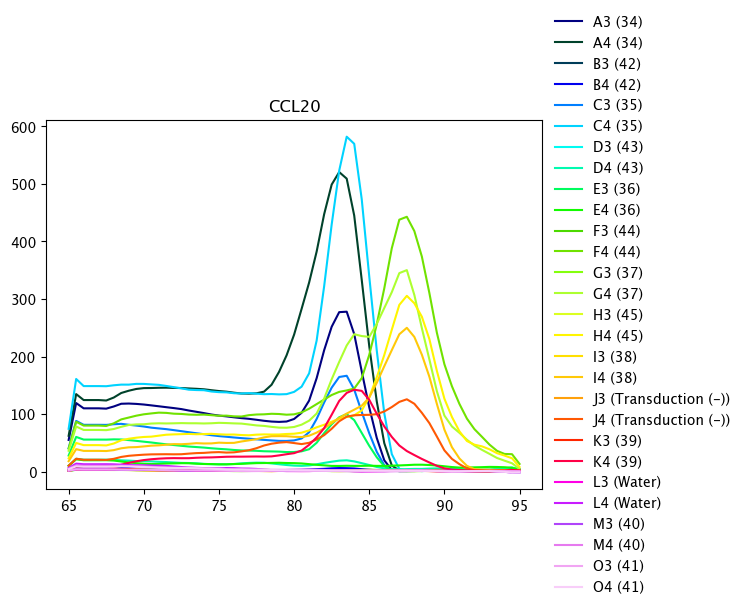

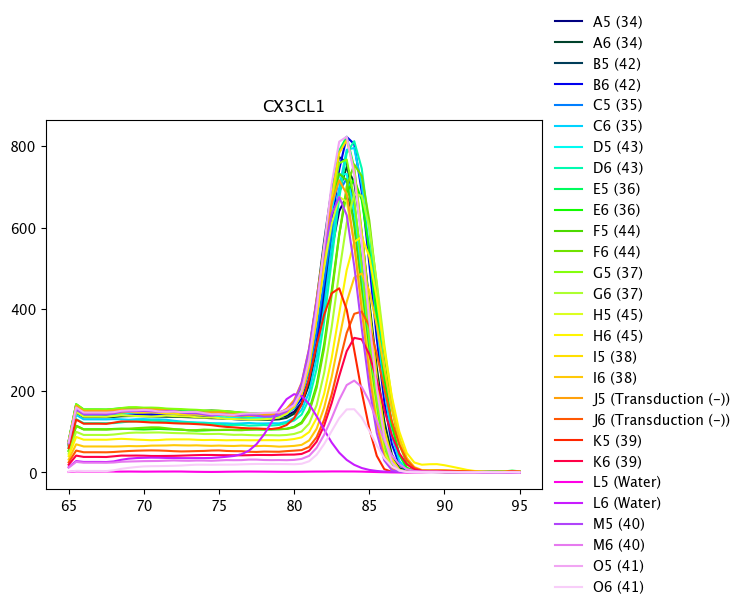

In [ ]:
mcdf = process_mc_384(path+"20230925_EXPJ30_qPCR -  Melt Curve Derivative Results_SYBR.csv", GOI_list, cell_lines)

# empty_wells_mc = [letter + "2" for letter in string.ascii_uppercase[:14]] + \
#     [letter + "4" for letter in string.ascii_uppercase[:14]] + \
#     [letter + "6" for letter in string.ascii_uppercase[:14]]

mcdf.dropna(inplace=True)
# mcdf = mcdf[~mcdf["index"].isin(empty_wells_mc)]

for gene in pd.Series(GOI_list).unique():
    if gene is not None:
        plot_mc_384(mcdf, gene, cmap='gist_ncar')
        # plot_mc_384(mcdf.loc[mcdf['index'].isin(['O2', 'O4', 'O6', 'P2', 'P4', 'P6'])], gene)

# **TEMP** -- development for improvements in qPCR scripts
Goal: make the qPCR analysis scripts more flexible for different sample layouts

In [5]:
import pandas as pd
import numpy as np

def define_genes_samples(ct_df, genes_list, samples_dict):
    GOI_wells = []
    samples_wells = []
    for well in ct_df['Well'].values.tolist():
        GOI_wells.append(genes_list[int(well[1:3])-1])
        samples_wells.append(samples_dict.get(well[0]))
    ct_df['GOI'] = GOI_wells
    ct_df['Sample'] = samples_wells
    return ct_df

ctdf = pd.read_csv(path+'20230925_EXPJ30_qPCR -  Quantification Cq Results.csv')
define_genes_samples(ctdf, GOI_list, cell_lines)
ctdf
# get_ct_384(ctdf)

,Unnamed: 0,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Set Point,Well Note,GOI
0,NaN,A01,SYBR,NaN,Unkn,34,NaN,NaN,0.000000,0,NaN,NaN,0.0,0,72,NaN,ACTB
1,NaN,A02,SYBR,NaN,Unkn,34,NaN,24.470224,24.470224,0,NaN,NaN,NaN,0,72,NaN,ACTB
2,NaN,A03,SYBR,NaN,Unkn,34,NaN,42.198038,42.198038,0,NaN,NaN,NaN,0,72,NaN,CCL20
3,NaN,A04,SYBR,NaN,Unkn,34,NaN,38.112307,38.112307,0,NaN,NaN,NaN,0,72,NaN,CCL20
4,NaN,A05,SYBR,NaN,Unkn,34,NaN,29.387316,29.387316,0,NaN,NaN,NaN,0,72,NaN,CX3CL1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,NaN,P20,SYBR,NaN,Unkn,NaN,NaN,NaN,0.000000,0,NaN,NaN,0.0,0,72,NaN,None
380,NaN,P21,SYBR,NaN,Unkn,NaN,NaN,NaN,0.000000,0,NaN,NaN,0.0,0,72,NaN,None
381,NaN,P22,SYBR,NaN,Unkn,NaN,NaN,NaN,0.000000,0,NaN,NaN,0.0,0,72,NaN,None
382,NaN,P23,SYBR,NaN,Unkn,NaN,NaN,NaN,0.000000,0,NaN,NaN,0.0,0,72,NaN,None


#### Format:
csv w A - P, 1 - 24 by default

code will look to see if the rows are letter names -- all that aren't will be excluded UNLESS ***ALL*** of them are letters -- in which case look for samples

- any samples not laid out row-wise should have sample name in the row

- AND if anything funky where gene =/= column, let's have it as sample / gene and then can do ```f"".split("_")```

In [112]:
# Stick to convention of one col = 1 gene for now
import string

class Well():
    def __init__(self, sample=None, gene=None):
        self.gene = gene
        self.sample = sample
    def __str__(self):
        return f"Well with {self.sample} and gene {self.gene}"

class Plate():
    def __init__(self, nrows = 16, ncolumns = 24):
        self.wells = {}
        self.nrows = nrows
        self.ncolumns = ncolumns
        self.create_wells()
    def create_wells(self):
        # Initialize a plate of the size; unrelated to filling in samples
        rows = string.ascii_uppercase[:self.nrows]
        for row in rows:
            for col in range(1, self.ncolumns+1):
                self.wells[f"{row}{f'{col:02}'}"] = Well()
    def __str__(self):
        return None

class qPCR():
    def __init__(self, layout:str, cq = None, mc = None):
        self.layout = pd.read_csv(layout, index_col=0)
        self.layout.dropna(axis=0, how='all', inplace=True)
        self.layout.dropna(axis=1, how='all', inplace=True)
        self.plate = Plate(*self.layout.shape)
    def assign_wells(self):
        if all([i in string.ascii_uppercase for i in out.index]): # if rows are NOT sample names
            if all([c in [str(i) for i in range(1, self.plate.nrows+1)] for c in self.layout.columns]): # If columns are NOT gene names
            # Time to look for samples individually
                for row in self.layout.index:
                    for col in self.layout.columns:
                        self.plate.wells[f"{row}{f'{int(col):02}'}"].sample, \
                        self.plate.wells[f"{row}{f'{int(col):02}'}"].gene = f"{self.layout.loc[row, col]}".split("_")
            else: # If unique samples, but still columns are genes
                for col in range(len(self.layout.columns)):
                    if self.layout.columns[col] not in [str(i) for i in range(1, self.plate.nrows+1)]:
                        for i in self.layout.index: # Wells per column
                            self.plate.wells[f"{i}{f'{col+1:02}'}"].gene = self.layout.columns[col]
                            self.plate.wells[f"{i}{f'{col+1:02}'}"].sample = self.layout.loc[i, self.layout.columns[col]]
        else: # If the plate is in the format I'm used to: 1 row 1 sample, 1 col 1 gene
            # The below for loop should have the relevant code for iterating thru a column to get gene there, but need to implement similar looking at sample this time
                    #         for col in range(len(self.layout.columns)):
                    # if self.layout.columns[col] not in [str(i) for i in range(1, self.plate.nrows+1)]:
                    #     for i in self.layout.index: # Wells per column
                    #         self.plate.wells[f"{i}{f'{col+1:02}'}"].gene = self.layout.columns[col]
                    # not necessary:        self.plate.wells[f"{i}{f'{col+1:02}'}"].sample = self.layout.loc[i, self.layout.columns[col]]

            pass
# plate = Plate()
# plate.wells#['A1'].gene = 'ACTB'
# print(plate.wells['A1'])

sample = qPCR("../instrument_output_analysis/csvtest.csv")
sample.assign_wells()
print(sample.plate.wells['E02'])

Well with 3C_ACTB and gene CXCL10


In [26]:
from icecream import ic
# out = pd.DataFrame({"ACTB" : ['A1', 'A2', 'A3']})
# out
out = pd.read_csv("../instrument_output_analysis/csvtest.csv", index_col=0)
out.dropna(axis=0, how='all', inplace=True)
out.dropna(axis=1, how='all', inplace=True)
# print(out)
out.shape
qPCR("../instrument_output_analysis/csvtest.csv").plate

In [46]:
a = 1


'01'

In [272]:
import random
codontab = {
    'TCA': 'S',    # Serina
    'TCC': 'S',    # Serina
    'TCG': 'S',    # Serina
    'TCT': 'S',    # Serina
    'TTC': 'F',    # Fenilalanina
    'TTT': 'F',    # Fenilalanina
    'TTA': 'L',    # Leucina
    'TTG': 'L',    # Leucina
    'TAC': 'Y',    # Tirosina
    'TAT': 'Y',    # Tirosina
    'TAA': '*',    # Stop
    'TAG': '*',    # Stop
    'TGC': 'C',    # Cisteina
    'TGT': 'C',    # Cisteina
    'TGA': '*',    # Stop
    'TGG': 'W',    # Triptofano
    'CTA': 'L',    # Leucina
    'CTC': 'L',    # Leucina
    'CTG': 'L',    # Leucina
    'CTT': 'L',    # Leucina
    'CCA': 'P',    # Prolina
    'CCC': 'P',    # Prolina
    'CCG': 'P',    # Prolina
    'CCT': 'P',    # Prolina
    'CAC': 'H',    # Histidina
    'CAT': 'H',    # Histidina
    'CAA': 'Q',    # Glutamina
    'CAG': 'Q',    # Glutamina
    'CGA': 'R',    # Arginina
    'CGC': 'R',    # Arginina
    'CGG': 'R',    # Arginina
    'CGT': 'R',    # Arginina
    'ATA': 'I',    # Isoleucina
    'ATC': 'I',    # Isoleucina
    'ATT': 'I',    # Isoleucina
    'ATG': 'M',    # Methionina
    'ACA': 'T',    # Treonina
    'ACC': 'T',    # Treonina
    'ACG': 'T',    # Treonina
    'ACT': 'T',    # Treonina
    'AAC': 'N',    # Asparagina
    'AAT': 'N',    # Asparagina
    'AAA': 'K',    # Lisina
    'AAG': 'K',    # Lisina
    'AGC': 'S',    # Serina
    'AGT': 'S',    # Serina
    'AGA': 'R',    # Arginina
    'AGG': 'R',    # Arginina
    'GTA': 'V',    # Valina
    'GTC': 'V',    # Valina
    'GTG': 'V',    # Valina
    'GTT': 'V',    # Valina
    'GCA': 'A',    # Alanina
    'GCC': 'A',    # Alanina
    'GCG': 'A',    # Alanina
    'GCT': 'A',    # Alanina
    'GAC': 'D',    # Acido Aspartico
    'GAT': 'D',    # Acido Aspartico
    'GAA': 'E',    # Acido Glutamico
    'GAG': 'E',    # Acido Glutamico
    'GGA': 'G',    # Glicina
    'GGC': 'G',    # Glicina
    'GGG': 'G',    # Glicina
    'GGT': 'G'     # Glicina
}
thy1_1 = "ATGAACCCAGCCATCAGCGTCGCTCTCCTGCTCTCAGTCTTGCAGGTGTCCCGAGGGCAGAAGGTGACCAGCCTGACAGCCTGCCTGGTGAACCAAAACCTTCGCCTGGACTGCCGCCATGAGAATAACACCAAGGATAACTCCATCCAGCATGAGTTCAGCCTGACCCGAGAGAAGAGGAAGCACGTGCTCTCAGGCACCCTTGGGATACCCGAGCACACGTACCGCTCCCGCGTCACCCTCTCCAACCAGCCCTATATCAAGGTCCTTACCCTAGCCAACTTCACCACCAAGGATGAGGGCGACTACTTTTGTGAGCTTCGCGTGAGCGGCGCGAATCCCATGAGCTCCAACAAGAGTATCAGTGTGTATAGAGACAAGCTGGTCAAGTGTGGCGGCATAAGCCTGCTGGTTCAGAACACATCCTGGATGCTGCTGCTGCTGCTTTCCCTCTCCCTCCTCCAAGCCCTGGACTTCATTTCTCTGTGA"
# for codon in thy1_1[]
n = 3
thy11_codons = [thy1_1[i:i+n] for i in range(0, len(thy1_1), n)]
aaseq = [codontab[i] for i in thy11_codons]
aa_codons = {aa : [i for i in codontab.keys() if codontab[i] == aa] for codon, aa in codontab.items()}
'''randomized_codons = [random.choice(aa_codons[i]) for i in aaseq]
print([aa_codons[i] for i in aaseq])
randomized_protein = [codontab[i] for i in randomized_codons]
print(thy1_1)
print("".join(randomized_codons))
print("".join(aaseq) == "".join(randomized_protein))'''
def random_thy11():
    randomized_codons = [random.choice(aa_codons[i]) for i in aaseq]
    # print([aa_codons[i] for i in aaseq])
    randomized_protein = [codontab[i] for i in randomized_codons]
    # print(thy1_1)
    print("".join(randomized_codons))
    # print("".join(aaseq) == "".join(randomized_protein))
    return
def random_thy11_maxdiff():
    randomized_codons = []
    for codon in thy11_codons:
        aa_i = codontab[codon]
        if len(aa_codons[aa_i]) > 1:
            randomized_codons.append(random.choice([i for i in aa_codons[aa_i] if i != codon]))
        else:
            randomized_codons.append(codon)
    print("".join(randomized_codons))
    # print([codontab[i] for i in randomized_codons] == aaseq)
    return
# random.choice(aa_codons[i]) for i in aaseq
# print([aa_codons[i] for i in aaseq])
# randomized_protein = [codontab[i] for i in randomized_codons]
# print(thy1_1)
# print("".join(randomized_codons))
# print("".join(aaseq) == "".join(randomized_protein))
for i in range(5):
    random_thy11()
    random_thy11_maxdiff()

ATGAACCCAGCCATTTCGGTCGCGTTGCTGCTGTCGGTGTTGCAGGTGTCTCGGGGACAAAAGGTAACTTCTTTGACTGCGTGCCTTGTGAATCAAAATTTACGGTTGGATTGTCGGCACGAGAACAATACCAAAGATAACTCTATTCAACATGAGTTTTCTCTTACGCGAGAGAAGCGCAAACATGTATTATCGGGCACCCTTGGTATTCCTGAGCATACCTATCGCAGTCGAGTCACTCTTAGCAACCAGCCATATATTAAAGTCTTAACCCTGGCGAATTTTACTACTAAAGATGAAGGAGATTACTTCTGCGAACTCCGCGTTTCAGGCGCAAATCCTATGTCGTCAAATAAAAGCATATCCGTTTACCGTGACAAGCTGGTTAAATGTGGCGGAATTTCGCTACTGGTCCAGAATACAAGTTGGATGCTCCTTTTGCTCCTATCTCTGTCTTTACTACAAGCGCTGGACTTCATTAGCTTGTAA
ATGAATCCCGCTATTTCAGTAGCGCTGCTACTGAGCGTGTTACAAGTTTCAAGGGGACAAAAAGTTACGTCGTTAACGGCATGTCTCGTCAATCAGAATTTAAGGCTAGATTGTCGTCACGAAAACAATACAAAAGACAATAGCATTCAACACGAATTTAGTTTGACGAGGGAAAAACGAAAACATGTCTTGTCGGGTACGTTGGGAATTCCTGAACATACCTATCGAAGCCGGGTTACACTATCAAATCAACCGTACATTAAAGTGTTAACGCTGGCGAATTTTACTACGAAAGACGAAGGAGATTATTTCTGCGAACTCCGAGTATCGGGAGCTAACCCGATGTCTAGTAATAAATCTATATCTGTATACCGGGATAAACTTGTGAAATGCGGGGGAATTTCCCTTCTTGTGCAAAATACCTCATGGATGTTGTTATTATTGTTAAGTTTGAGTTTGCTACAGGCTCTAGATTTTATCTCACTTTAG
ATGAACCCGGCGATTAGCGT

In [ ]:
badgenes = ["KITLG", "NF1", "ACKR3", "CD8A", "TNFRSF17", "BMP1", "CD3D", "TLR9"]